### 导入库

In [2]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [3]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [4]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [5]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.0009
target_size = 256
epochs = 10

In [6]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [7]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [8]:
model = VGG16()

In [10]:
model.load_state_dict(torch.load("./model/MPFA_63.pth"), strict=False)

<All keys matched successfully>

In [11]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

model.train()

# layers = [model.conv1_1, model.conv1_2, model.conv2_1, model.conv2_2,
#          model.conv3_1, model.conv3_2, model.conv3_3,
#          model.conv4_1, model.conv4_2, model.conv4_3,
#          model.conv5_1, model.conv5_2, model.conv5_3]

# for layer in layers:
#     for par in layer.parameters():
#         par.requires_grad = False

VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling3): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1,

In [12]:
for epoch in range(64, 75):
    criterion = EdgeHoldLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                weight_decay=0,
                                momentum=0.9)
    print("lr:{:.10f}".format(learning_rate))
    start_time = time.time()
    learning_rate = learning_rate - learning_rate * 0.1
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}"
                      .format(epoch, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")
    torch.save(model.state_dict(),"./model/MPFA_{}.pth".format(epoch))

lr:0.0009000000
Epoch:64 loss:0.42097437381744385 Batch:100/2639 acc:0.9217532277107239 pre:0.9324837923049927 recall:0.8763599395751953 F-measure:0.9171290993690491
Epoch:64 loss:0.42581331729888916 Batch:200/2639 acc:0.9216784238815308 pre:0.9300746917724609 recall:0.8751504421234131 F-measure:0.9149110913276672
Epoch:64 loss:0.42409467697143555 Batch:300/2639 acc:0.9201049208641052 pre:0.9265078902244568 recall:0.8741364479064941 F-measure:0.9119354486465454
Epoch:64 loss:0.41086938977241516 Batch:400/2639 acc:0.9202350974082947 pre:0.9292903542518616 recall:0.8741012215614319 F-measure:0.9139571189880371
Epoch:64 loss:0.4166393280029297 Batch:500/2639 acc:0.920641303062439 pre:0.9303942322731018 recall:0.8748450875282288 F-measure:0.9150077700614929
Epoch:64 loss:0.42080336809158325 Batch:600/2639 acc:0.9202641844749451 pre:0.9306958317756653 recall:0.8771724700927734 F-measure:0.9159077405929565
Epoch:64 loss:0.42152804136276245 Batch:700/2639 acc:0.9203783273696899 pre:0.93082547

lr:0.0007290000
Epoch:66 loss:0.4253409802913666 Batch:100/2639 acc:0.9232165217399597 pre:0.9280757904052734 recall:0.8923812508583069 F-measure:0.9176028370857239
Epoch:66 loss:0.42359745502471924 Batch:200/2639 acc:0.9219086766242981 pre:0.9324583411216736 recall:0.8921782970428467 F-measure:0.9211021065711975
Epoch:66 loss:0.43149012327194214 Batch:300/2639 acc:0.9220899939537048 pre:0.9314616918563843 recall:0.8862251043319702 F-measure:0.9187279343605042
Epoch:66 loss:0.418376624584198 Batch:400/2639 acc:0.921260416507721 pre:0.9311808347702026 recall:0.8820765614509583 F-measure:0.9173022508621216
Epoch:66 loss:0.41323158144950867 Batch:500/2639 acc:0.9218825101852417 pre:0.9308485388755798 recall:0.8830440044403076 F-measure:0.9174215793609619
Epoch:66 loss:0.42386865615844727 Batch:600/2639 acc:0.9214730262756348 pre:0.9295383095741272 recall:0.8818675875663757 F-measure:0.9160940647125244
Epoch:66 loss:0.42684370279312134 Batch:700/2639 acc:0.9217072129249573 pre:0.9309255480

lr:0.0005904900
Epoch:68 loss:0.41561776399612427 Batch:100/2639 acc:0.9241769313812256 pre:0.9368366003036499 recall:0.8898637890815735 F-measure:0.9240992665290833
Epoch:68 loss:0.42271000146865845 Batch:200/2639 acc:0.9239703416824341 pre:0.9377717971801758 recall:0.8873355388641357 F-measure:0.9235532879829407
Epoch:68 loss:0.4284822642803192 Batch:300/2639 acc:0.9228622913360596 pre:0.9342436790466309 recall:0.8833927512168884 F-measure:0.9199644327163696
Epoch:68 loss:0.42068246006965637 Batch:400/2639 acc:0.9235606789588928 pre:0.9322742223739624 recall:0.8848918676376343 F-measure:0.9187890291213989
Epoch:68 loss:0.410351425409317 Batch:500/2639 acc:0.9227030277252197 pre:0.9314482808113098 recall:0.8856872320175171 F-measure:0.9184286594390869
Epoch:68 loss:0.4135931730270386 Batch:600/2639 acc:0.922061562538147 pre:0.9301150441169739 recall:0.8857308030128479 F-measure:0.9173588156700134
Epoch:68 loss:0.4262852668762207 Batch:700/2639 acc:0.9224687814712524 pre:0.930053412914

lr:0.0004782969
Epoch:70 loss:0.4150487184524536 Batch:100/2639 acc:0.9254211187362671 pre:0.9345302581787109 recall:0.8938097357749939 F-measure:0.9235863089561462
Epoch:70 loss:0.42372560501098633 Batch:200/2639 acc:0.923866331577301 pre:0.9319556951522827 recall:0.8892223238945007 F-measure:0.9203941822052002
Epoch:70 loss:0.4280344247817993 Batch:300/2639 acc:0.9238105416297913 pre:0.9318114519119263 recall:0.8864922523498535 F-measure:0.9192285537719727
Epoch:70 loss:0.4296302795410156 Batch:400/2639 acc:0.9240543842315674 pre:0.9331685304641724 recall:0.8871127963066101 F-measure:0.9203404784202576
Epoch:70 loss:0.42345157265663147 Batch:500/2639 acc:0.9243480563163757 pre:0.9333651661872864 recall:0.8883737325668335 F-measure:0.9208618402481079
Epoch:70 loss:0.422638475894928 Batch:600/2639 acc:0.9244996309280396 pre:0.9330121278762817 recall:0.8882833123207092 F-measure:0.9206262230873108
Epoch:70 loss:0.4118601977825165 Batch:700/2639 acc:0.924010694026947 pre:0.93452847003936

lr:0.0003874205
Epoch:72 loss:0.41694068908691406 Batch:100/2639 acc:0.9225600361824036 pre:0.9296227693557739 recall:0.8813130855560303 F-measure:0.9144458770751953
Epoch:72 loss:0.42640236020088196 Batch:200/2639 acc:0.9205790758132935 pre:0.9312297701835632 recall:0.8841284513473511 F-measure:0.9171851873397827
Epoch:72 loss:0.42174041271209717 Batch:300/2639 acc:0.9204738736152649 pre:0.9331871867179871 recall:0.8861374258995056 F-measure:0.9195786714553833
Epoch:72 loss:0.40551573038101196 Batch:400/2639 acc:0.9207908511161804 pre:0.9325230121612549 recall:0.8868662118911743 F-measure:0.9195145964622498
Epoch:72 loss:0.4268815517425537 Batch:500/2639 acc:0.9215392470359802 pre:0.9329103827476501 recall:0.8839508891105652 F-measure:0.9190718531608582
Epoch:72 loss:0.4173656702041626 Batch:600/2639 acc:0.9223105907440186 pre:0.9338541030883789 recall:0.8849488496780396 F-measure:0.9201488494873047
Epoch:72 loss:0.4177509546279907 Batch:700/2639 acc:0.9218811988830566 pre:0.934463560

lr:0.0003138106
Epoch:74 loss:0.41922909021377563 Batch:100/2639 acc:0.9233666658401489 pre:0.9242027997970581 recall:0.8940579891204834 F-measure:0.9156343340873718
Epoch:74 loss:0.4097822308540344 Batch:200/2639 acc:0.9236802458763123 pre:0.9287879467010498 recall:0.8898034691810608 F-measure:0.9178600907325745
Epoch:74 loss:0.42440417408943176 Batch:300/2639 acc:0.9219879508018494 pre:0.9278358221054077 recall:0.8838425874710083 F-measure:0.9154565930366516
Epoch:74 loss:0.4137846827507019 Batch:400/2639 acc:0.9224808812141418 pre:0.9311771988868713 recall:0.8873162865638733 F-measure:0.9189340472221375
Epoch:74 loss:0.42282503843307495 Batch:500/2639 acc:0.9225518703460693 pre:0.9307619333267212 recall:0.8861717581748962 F-measure:0.9182185530662537
Epoch:74 loss:0.4263775050640106 Batch:600/2639 acc:0.9221300482749939 pre:0.9317312836647034 recall:0.8874925971031189 F-measure:0.9193828701972961
Epoch:74 loss:0.4255392551422119 Batch:700/2639 acc:0.9217050671577454 pre:0.9325337409

In [13]:
# torch.save(model.state_dict(),"./model/MPFA_47.pth")

In [14]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [15]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [16]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [17]:
msk.shape

torch.Size([256, 256, 1])

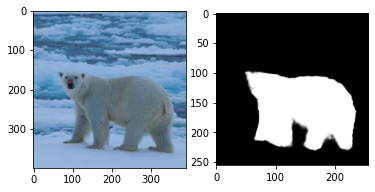

In [18]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

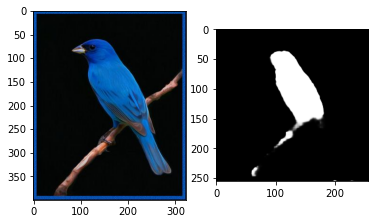

In [19]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

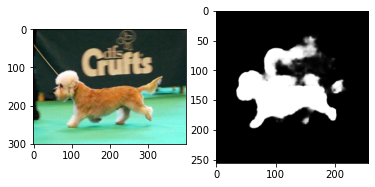

In [20]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()